In [2]:
# Import denpendecies
import requests
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Extracting data from Postgres using APIs

In [3]:
# Define a list of table names and their corresponding API endpoints
tables = {
            
        "Bureau" : 'http://127.0.0.1:5000/bureau',
        "Bureau_balance" : 'http://127.0.0.1:5000/bureau_balance',
        "Credit_card_balance" : 'http://127.0.0.1:5000/credit_card_balance',
        "Installments_payments" : 'http://127.0.0.1:5000/installments_payments',
        "POS_CASH_balance" : 'http://127.0.0.1:5000/pOS_CASH_balance',
        "Previous_application" : 'http://127.0.0.1:5000/previous_application',
        "Application_train" : 'http://127.0.0.1:5000/application_train'
}

# Dictionary to store DataFrames for each table
dataframes = {}

# Make API requests to get data from each table
for table_name, endpoint in tables.items():
    response = requests.get(endpoint)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Convert API response to a DataFrame and store it in the dictionary
        dataframes[table_name] = pd.DataFrame(response.json())
        print(f"Data for {table_name} fetched successfully.")
    else:
        print(f"Error: Unable to fetch data from {table_name}. Status code: {response.status_code}")

Data for Bureau fetched successfully.
Data for Bureau_balance fetched successfully.
Data for Credit_card_balance fetched successfully.
Data for Installments_payments fetched successfully.
Data for POS_CASH_balance fetched successfully.
Data for Previous_application fetched successfully.
Data for Application_train fetched successfully.


## Combining DataFrames

In [4]:
# Merge tables based on specified keys
merged_table = dataframes["Application_train"]

# Merge POS_CASH_balance, Installments_payments, Credit_card_balance based on SK_ID_PREV
for table_name in ["POS_CASH_balance", "Installments_payments", "Credit_card_balance", "Previous_application"]:
    if table_name in dataframes:
        # Specify suffixes to avoid duplicate column names
        merged_table = pd.merge(merged_table, dataframes[table_name], on='SK_ID_CURR', how='left', suffixes=('', f'_{table_name}'))

# Merge Bureau and Bureau_balance based on SK_ID_BUREAU
if "Bureau" in dataframes and "Bureau_balance" in dataframes:
    bureau_merged = pd.merge(dataframes["Bureau"], dataframes["Bureau_balance"], on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bureau_balance'))
    merged_table = pd.merge(merged_table, bureau_merged, on='SK_ID_CURR', how='left')

# Display the final merged table with unique columns
unique_columns = merged_table.columns.unique()
final_table = merged_table[unique_columns]

# Display the final table
final_table.head()

,AMT_ANNUITY_x,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CREDIT_CURRENCY,CREDIT_DAY_OVERDUE,CREDIT_TYPE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_CREDIT_UPDATE,DAYS_ENDDATE_FACT,SK_ID_BUREAU,MONTHS_BALANCE_y,STATUS
0,24700.5,406597.5,351000.0,202500.0,0.000,0.000000,0.000000,0.000000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,0.007,0.006403,0.267398,0.265477,0.034359,1.899977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning & Encoding categorical variables

In [5]:
# Drop duplicate values
data_df = final_table.drop_duplicates()

In [6]:
# Fill na with (0)
data_df=data_df.fillna(0)

In [7]:
# Changing CODE_GENDER to 0 and 1 to match model
data_df['CODE_GENDER'] = data_df['CODE_GENDER'].replace({'F': 0, 'M': 1})

In [8]:
# Changing FLAG_OWN_REALTY AND FLAG_OWN_CAR to 0 and 1 to match model
data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']] = data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']].replace({'Y': 1, 'N': 0}).astype(int)

## Assigning Values to X and y

In [9]:
# Selecting X features
X = data_df.drop(columns=['TARGET'], axis=1)

In [10]:
# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X).astype(int)

In [11]:
# select Target variable
y = data_df['TARGET'].values

## Machine learning model: Randon Forest Classifier

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance

scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities = model.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions = (positive_class_probabilities > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[54948     0]
 [ 1591  2644]]

Accuracy: 0.9731172803000862


In [13]:
report = classification_report(y_test, binary_predictions)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     54948
           1       1.00      0.62      0.77      4235

    accuracy                           0.97     59183
   macro avg       0.99      0.81      0.88     59183
weighted avg       0.97      0.97      0.97     59183



## Assigning risk levels

In [14]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels = pd.cut(positive_class_probabilities, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities, 'Risk Level': risk_levels})
result_df.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df = result_df.drop_duplicates()
result_df = result_df.reset_index(drop=True)
# Print the result DataFrame
print(result_df)

       SK_ID_CURR  Probability     Risk Level
0          100002         0.20  Very Low Risk
1          100007         0.00  Very Low Risk
2          100007         0.01  Very Low Risk
3          100008         0.03  Very Low Risk
4          100009         0.01  Very Low Risk
...           ...          ...            ...
37431      216076         0.20  Very Low Risk
37432      216081         0.21       Low Risk
37433      216084         0.21       Low Risk
37434      216085         0.07  Very Low Risk
37435      216090         0.07  Very Low Risk

[37436 rows x 3 columns]


## Top contributing features

In [15]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted = importances_sorted[:30]
sorted_df = pd.DataFrame(importances_sorted)
sorted_df[1]

0                    DAYS_REGISTRATION
1                      DAYS_ID_PUBLISH
2                           DAYS_BIRTH
3                           SK_ID_CURR
4               DAYS_LAST_PHONE_CHANGE
5                        DAYS_EMPLOYED
6                           AMT_CREDIT
7                        AMT_ANNUITY_x
8                      AMT_GOODS_PRICE
9                     AMT_INCOME_TOTAL
10             HOUR_APPR_PROCESS_START
11          AMT_REQ_CREDIT_BUREAU_YEAR
12            OBS_60_CNT_SOCIAL_CIRCLE
13                  DAYS_ENTRY_PAYMENT
14            OBS_30_CNT_SOCIAL_CIRCLE
15    SK_ID_PREV_Installments_payments
16                         OWN_CAR_AGE
17                     DAYS_INSTALMENT
18                      AMT_INSTALMENT
19      SK_ID_PREV_Credit_card_balance
20                         AMT_PAYMENT
21                        SK_ID_BUREAU
22                      CNT_INSTALMENT
23                          SK_ID_PREV
24                     CNT_FAM_MEMBERS
25               NUM_INST

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

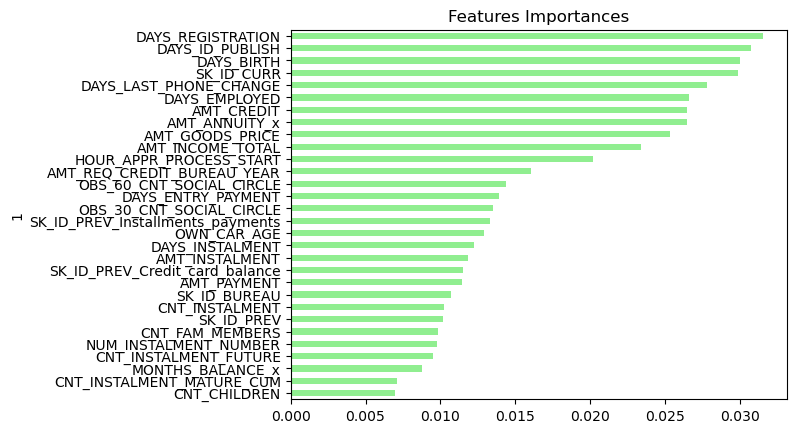

In [16]:
sorted_df.set_index(sorted_df[1], inplace=True)
sorted_df.drop(columns=1, inplace=True)
sorted_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = sorted_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

## Selecting top contributing features

In [17]:
X  = data_df[["CNT_FAM_MEMBERS",
                "OWN_CAR_AGE",
                "SK_ID_CURR",
                "AMT_INCOME_TOTAL",
                "AMT_REQ_CREDIT_BUREAU_YEAR",
                "OBS_30_CNT_SOCIAL_CIRCLE",
                "OBS_60_CNT_SOCIAL_CIRCLE",
                "AMT_ANNUITY_x",
                "CNT_INSTALMENT_MATURE_CUM",
                "AMT_PAYMENT",
                "DAYS_ENTRY_PAYMENT",
                "AMT_INSTALMENT",
                "DAYS_INSTALMENT",
                "NUM_INSTALMENT_NUMBER",
                "CNT_INSTALMENT_FUTURE",
                "CNT_INSTALMENT",
                "MONTHS_BALANCE_Credit_card_balance",
                "MONTHS_BALANCE_x"]]

In [18]:
# Fillna (0) in the selective features
X_features = X.fillna(0)

In [19]:
# Selective target variable
y_features = data_df['TARGET']

## Machine learning model: Random Forest Classifier

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model_features = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[54941     7]
 [ 1914  2321]]

Accuracy: 0.9675413547809337


In [21]:
report = classification_report(y_test, binary_predictions_features)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     54948
           1       1.00      0.55      0.71      4235

    accuracy                           0.97     59183
   macro avg       0.98      0.77      0.85     59183
weighted avg       0.97      0.97      0.96     59183



In [22]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels_features = pd.cut(positive_class_probabilities_features, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df_features = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities_features, 'Risk Level': risk_levels_features})
result_df_features.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df_features = result_df_features.drop_duplicates()
result_df_features = result_df_features.reset_index(drop=True)
# Print the result DataFrame
print(result_df_features)

       SK_ID_CURR  Probability     Risk Level
0          100002         0.12  Very Low Risk
1          100007         0.00  Very Low Risk
2          100008         0.01  Very Low Risk
3          100009         0.09  Very Low Risk
4          100011         0.05  Very Low Risk
...           ...          ...            ...
38310      216076         0.16  Very Low Risk
38311      216081         0.11  Very Low Risk
38312      216084         0.11  Very Low Risk
38313      216085         0.21       Low Risk
38314      216090         0.17  Very Low Risk

[38315 rows x 3 columns]


In [23]:
import joblib
joblib.dump(model_features, 'model_probability.joblib')

['model_probability.joblib']